In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Что за данные?!

Данные собраны из официального Google Play Market-а и включают в себя информацию о части приложений из разных категорий, с разным рейтингом и целевой аудиторией. Всего на одно приложение/игру - 13 характеристик. Сначала загрузим и выведем данные, чтобы посмотреть что вообще мы можем с ними сделать.

Ссылка на данные: https://www.kaggle.com/lava18/google-play-store-apps

In [2]:
df = pd.read_csv('googleplaystore.csv')

In [3]:
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Видим, что в данных есть пропуски и больше всего их в категории "рейтинг", наверное, наиболее интересной для нас, ведь по большой части только по ней можем определить "хорошесть" приложения, и удалять порядка 10% выборки тоже не хочется, нужно будет подумать что с этим делать. Но прежде нужно проверить данные на адекватность, проверить нет ли дупликатов.

In [5]:
print("Всего уникальных приложений: ", df.App.nunique())

Всего уникальных приложений:  9660


In [6]:
df[df.duplicated(subset=['App'], keep=False)].head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up


In [7]:
df.loc[df.App == "Coloring book moana"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2033,Coloring book moana,FAMILY,3.9,974,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


Проверив часть дубликатов выяснил, что они идентичны, просто изначально думал может будет смысл как-то объединить или еще провести какие-то манипуляции, но нужно по сути просто взять последнее включение, так как оно скорее будет чуть "свежее", больше оценок или типа того, но на самом деле тоже не критично. Удалим дупликаты.

In [8]:
df = df.drop_duplicates(subset=['App'], keep='last')

In [9]:
# df['Price'].unique()

In [10]:
df.loc[df.Price == "Everyone"].head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [11]:
df.drop(10472, axis=0, inplace=True)

In [12]:
df.shape

(9659, 13)

После удаления дупликатов, переведем колонки, которые возможно (и нужно) в числовой формат. Тут же нашел странный выброс в данных, удалим его. А также начнем постепенно приводить некоторые колонки к желаемому типу.

In [13]:
df['Price'] = df['Price'].replace(to_replace ='\$', value = '', regex = True)

In [14]:
df = df.astype({'Price': float, 'Reviews': int})

In [15]:
df.Reviews.nunique()

5332

In [16]:
# df[df.duplicated(subset=['Reviews'], keep=False)].head()

In [17]:
df['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

Доходим до колонки "Последнее обновление". Как таковое само по себе оно не несет особого смысла, и не сыграет роли ни при начальном анализе, ни тем более при обучении различных моделей, скорее даже будет вредить. Поэтому добавим колонку "Сколько времени прошло с последнего обновления", которая в теории покажет, что если времени прошло не много, то разработчики продолжают совершенствовать приложение и не забрасывают его, что несомненно хорошо. Данные были собраны в феврале 2019 года, будем отходить от этой даты. Это уже, конечно, более подходит под feature engineering, а не под eda, но сделаю сразу тут.

In [18]:
df['Last Updated'].unique()

array(['January 7, 2018', 'August 1, 2018', 'June 8, 2018', ...,
       'January 20, 2014', 'February 16, 2014', 'March 23, 2014'],
      dtype=object)

In [19]:
data_post = datetime.datetime(year=2019, month=2, day=3)

def splitting(st):
    m = []
    m = st.split()
    m[1] = m[1][:-1]
    MonthDict={ 1 : "January",
       2 : "February",
       3 : "March",
       4 : "April",
       5 : "May",
       6 : "June",
       7 : "July",
       8 : "August",
       9 : "September",
       10 : "October",
       11 : "November",
       12 : "December"
    }
    MonthDict_2 = dict((y,x) for x,y in MonthDict.items())
    return datetime.datetime(year=int(m[2]), month=int(MonthDict_2[m[0]]), day=int(m[1]))

def difference(st):
    return int((data_post - splitting(st)).days)

In [20]:
df['days_after_update'] = df['Last Updated'].apply(difference)

In [21]:
df.drop(columns=["Last Updated"],inplace=True)

In [22]:
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,days_after_update
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0.0,Everyone,Art & Design,1.0.0,4.0.3 and up,392
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,1.2.4,4.0.3 and up,186
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0.0,Teen,Art & Design,Varies with device,4.2 and up,240


Отчасти по субъективному мнению, могу предположить, что было бы неплохо чтобы разработчики выпускали хотя бы минорные обновления раз в несколько кварталов. Вроде как и игры в которые я когда-то играл, и приложения выпускали какие-то обновления за этот период, поэтому остановлюсь на нем. Хочу добавить еще колонку, для дальнейшей удобной группировки.

In [23]:
def how_much_time(tm):
    if tm <= 180:
        return "acctivly_follow"
    if tm > 180 and tm <= 365:
        return "middling_follow"
    if tm > 365:
        return "little_follow"

In [24]:
df['tracking'] = df['days_after_update'].apply(how_much_time)

In [25]:
df.shape

(9659, 14)

Было бы неплохо колонку "размер" также привести к числовому виду. Сделаем это.

In [26]:
def change_size(st):
    if st.find('M') != -1:
        return float(st.replace('M', ''))
    elif st.find('k') != -1:
        return float(st.replace('k', '')) * 0.00098
    else:
        return -1

In [27]:
df['Size'] = df['Size'].apply(change_size)

In [28]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,days_after_update,tracking
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0.0,Everyone,Art & Design,1.0.0,4.0.3 and up,392,little_follow
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0.0,Everyone,Art & Design,1.2.4,4.0.3 and up,186,middling_follow
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0.0,Teen,Art & Design,Varies with device,4.2 and up,240,middling_follow
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,1.1,4.4 and up,228,middling_follow
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,"50,000+",Free,0.0,Everyone,Art & Design,1.0,2.3 and up,679,little_follow


In [29]:
df.loc[df.Size == -1].head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,days_after_update,tracking
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,-1.0,"5,000,000+",Free,0.0,Everyone,Art & Design,Varies with device,2.3.3 and up,204,middling_follow
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,-1.0,"1,000,000+",Free,0.0,Everyone,Auto & Vehicles,Varies with device,Varies with device,188,middling_follow


In [30]:
df.loc[df.Size == -1].shape

(1227, 14)

Довольно много записей в данных, где размер зависит от устройства.

Посмотрим на следующую колонку - "Кол-во скачиваний". Разброс значений в колонке хоть и не большой и изначально хотел попробовать преобразовать ее также к числовому виду. Но делать этого не буду, так как достаточно неочевидный разброс значений. Единственное, думаю, что имеет смысл удалить приложения, которые скачивали 0 раз.

In [31]:
df.Installs.unique()

array(['10,000+', '5,000,000+', '50,000,000+', '100,000+', '50,000+',
       '1,000,000+', '10,000,000+', '5,000+', '500,000+',
       '1,000,000,000+', '100,000,000+', '1,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '500,000,000+', '0+', '0'], dtype=object)

In [36]:
to_del = ['0+', '0']

In [37]:
mask = df['Installs'].isin(to_del)
ind = df.loc[mask, 'Installs'].index

In [38]:
df.drop(index = ind, axis=0, inplace=True)

In [39]:
df.shape

(9644, 14)

Рассмотрим следующую колонку.

In [65]:
df['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [66]:
df['Content Rating'].value_counts()

Everyone           7891
Teen               1034
Mature 17+          393
Everyone 10+        321
Adults only 18+       3
Unrated               2
Name: Content Rating, dtype: int64

In [67]:
df.loc[df['Content Rating'] == 'Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver,days_after_update,tracking
7312,Best CG Photography,FAMILY,NaN,1,2.5,500+,Free,0.0,Unrated,Entertainment,3.0 and up,1320,little_follow
8266,DC Universe Online Map,TOOLS,4.1,1186,6.4,"50,000+",Free,0.0,Unrated,Tools,2.3.3 and up,2533,little_follow


In [68]:
df['Content Rating'] = df['Content Rating'].replace(["Adults only 18+", "Unrated"],["Mature 17+", "Everyone"])
df['Content Rating'].value_counts()

Everyone        7893
Teen            1034
Mature 17+       396
Everyone 10+     321
Name: Content Rating, dtype: int64

Итак, на данный момент имеем уже 4 преобразованные колонки. Колонка версия андройда также достаточно интересна. Если приложение доступно для андроида старшей версии, то большее кол-во людей может его установить (т.е. даже те, у кого старые девайсы), что повышает кол-во потенциальных пользователей. Однако не совсем ясно, какую версию считать оптимальной (ведь с другой стороны если приложение подходит для старших версий, то есть вероятность, что оно не такое "крутое"). Но нужно ли нам оценивать "крутость"? Зависит больше от конкретной задачи, и здесь нам, наверное, не нужно. Это были скорее мысли вслух. Так как я все равно информации не нашел о распространенности версий, поэтому оставлю эту колонку так, как есть.

In [40]:
df['Android Ver'].unique()

array(['4.0.3 and up', '4.2 and up', '4.4 and up', '2.3 and up',
       '3.0 and up', '4.1 and up', '4.0 and up', '2.3.3 and up',
       'Varies with device', '2.2 and up', '5.0 and up', '6.0 and up',
       '1.6 and up', '1.5 and up', '2.1 and up', '7.0 and up',
       '5.1 and up', '4.3 and up', '4.0.3 - 7.1.1', '2.0 and up',
       '3.2 and up', '4.4W and up', '7.1 and up', '7.0 - 7.1.1',
       '8.0 and up', '5.0 - 8.0', '3.1 and up', '2.0.1 and up',
       '4.1 - 7.1.1', nan, '5.0 - 6.0', '1.0 and up', '2.2 - 7.1.1',
       '5.0 - 7.1.1'], dtype=object)

Текущая версия приложения о многом не скажет, как мне кажется, поэтому я решил ее удалить.

In [41]:
df.drop(columns=["Current Ver"],inplace=True)

In [42]:
df.dtypes

App                   object
Category              object
Rating               float64
Reviews                int32
Size                 float64
Installs              object
Type                  object
Price                float64
Content Rating        object
Genres                object
Android Ver           object
days_after_update      int64
tracking              object
dtype: object

Вроде все необходимые подготовительные действия с данными проделаны, можем теперь посмотреть на распределение данных и как-то сгруппировать их.

## Exploratory data analysis

Перед тем как смотреть на распределения наших данных и зависимости их друг от друга, попробую выдвинуть пару гипотез, которые впоследствии проверю.
#### Гипотезы:
1. Рейтинг платных приложений будет выше, чем бесплатных.
2. Наиболее популярные категории связаны с семьей, развлечениями, модой/красотой.
3. Распределение рейтинга ожидаю, что будет симметрично.

### Графики распределений и не только

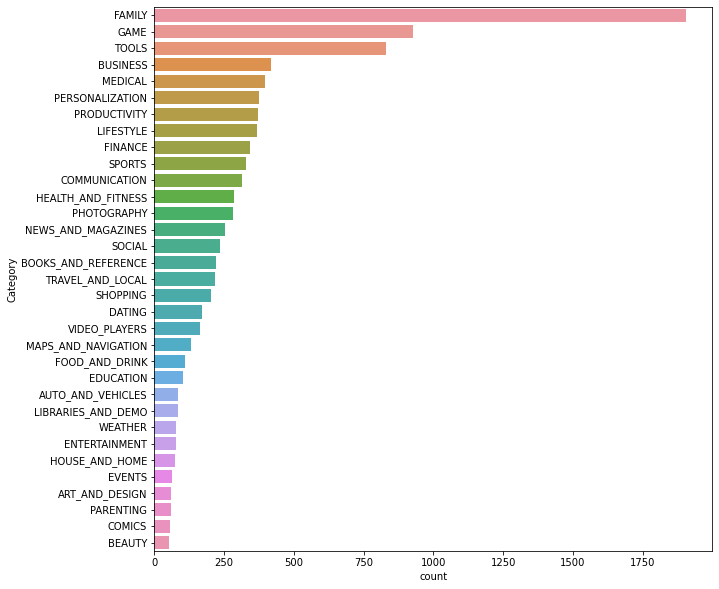

In [43]:
plt.figure(figsize=(10,10))
sns.countplot(y = df['Category'], order = df['Category'].value_counts().index)
plt.show()

In [44]:
df['Category'].value_counts().keys()[:7]

Index(['FAMILY', 'GAME', 'TOOLS', 'BUSINESS', 'MEDICAL', 'PERSONALIZATION',
       'PRODUCTIVITY'],
      dtype='object')

In [45]:
df['Genres'].value_counts().keys()[:7]

Index(['Tools', 'Entertainment', 'Education', 'Business', 'Medical',
       'Personalization', 'Productivity'],
      dtype='object')

Видно, что колонки "категория" и "жанр" очень схожи, по крайней мере, если вывести некоторое кол-во наиболее популярных, то они практически идентичны. И если семейные приложения в топе, что достаточно ожидаемо, то вот бизнесс и медицина слегка удивли, ровно также как и "мода/красота" на последнем месте. Люди все больше следят за своим здоровьем (так посмотрел у меня у самого стоит пару приложений из этой категории).

Посмотрим на распределние рейтинга. Из графика видно, что в целом приложений с оценкой ">4.0" неожиданно много.

<Figure size 720x720 with 0 Axes>

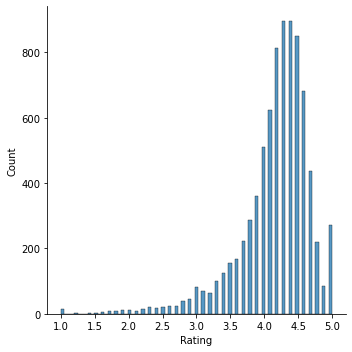

In [46]:
plt.figure(figsize=(10,10))
sns.displot(df['Rating'])
plt.show()

In [47]:
print('Всего приложений с оценкой меньше 4: {} и составляет это {}% от всего числа наблюдений'.
      format(df.loc[df.Rating < 4.0].shape[0], round(df.loc[df.Rating < 4.0].shape[0] / df.shape[0],1)*100))

Всего приложений с оценкой меньше 4: 1910 и составляет это 20.0% от всего числа наблюдений


Я, конечно, преполагал, что рейтинг не будет симметричен так как представлял изначально (думалось что будет что-то похожее на нормальное распределение если так можно сказать, но с центром в 3,4-3,6 (на и соответственно симметричное относительно центра)). Но что он будет так смещен в сторону высоких оценок слегка удивляет.

Стало интересно зависит ли рейтинг приложения от того является ли оно платным. И как показывает график ниже, различия есть (рейтинг платных приложений смещен в сторону более высоких оценок, но по большосу счету смещение незначительное).

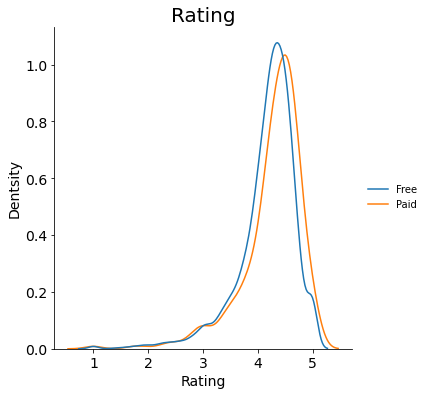

In [50]:
sns.displot({
        "Free": df[df.Type == 'Free'].Rating,
        "Paid": df[df.Type == 'Paid'].Rating
    },
    kind = "kde",
    common_norm = False # независимая нормализация каждого подмножества
)

plt.title('Rating', fontsize=20)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

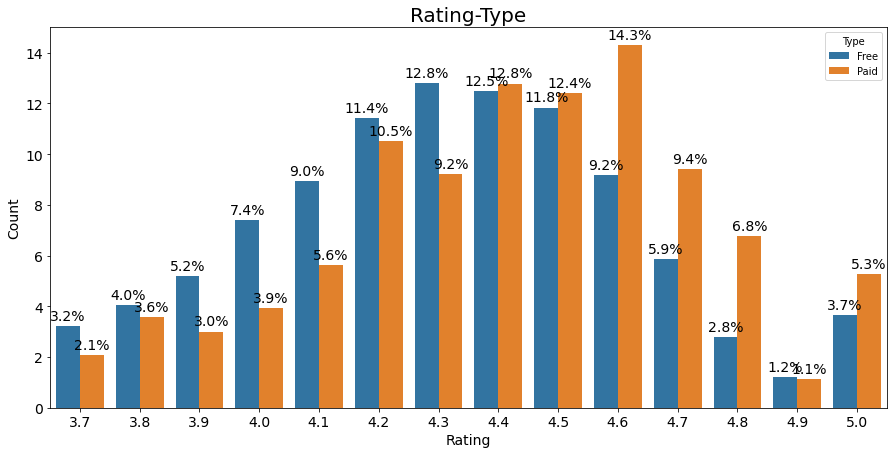

In [52]:
# Выберем приложения с оценкой более 3,6 и посмотрим на зависимости рейтинга от "платности"
df_rating_type = df.loc[df.Rating > 3.6]

plt.figure(figsize=(15, 7))

educ_def = (df_rating_type.groupby(['Type'])['Rating']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('Rating'))

ax = sns.barplot(x="Rating", y="percentage", hue="Type", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Rating-Type', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Rating', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Хотя вот этот график показывает уже больше интересной информации. Мы видим, что рейтинг бесплатных приложений "растет" до 4.3, после чего идет на снижение. А у платных рейтинг держится на 4.4-4.6 (достигая максимума (по кол-ву приложений) в позиции рейтинга - 4.6).

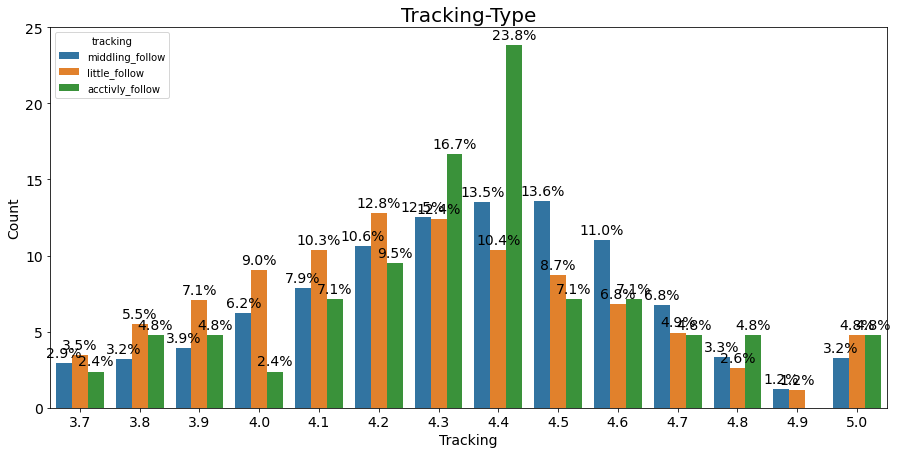

In [59]:
df_rating_type = df.loc[df.Rating > 3.6]

plt.figure(figsize=(15, 7))

educ_def = (df_rating_type.groupby(['tracking'])['Rating']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('Rating'))

ax = sns.barplot(x="Rating", y="percentage", hue="tracking", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Tracking-Type', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Tracking', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Не уверен, что это связано настолько напрямую, наверняка есть сопутствующие факторы, но любопытно заметить, что приложения, где разработчики мало следят за приложением (не выпускают обновления более года), у этих приложений рейтинг ниже. А соответственно, где выпскаются обновления хотя бы раз в год, рейтинг заметноо выше.

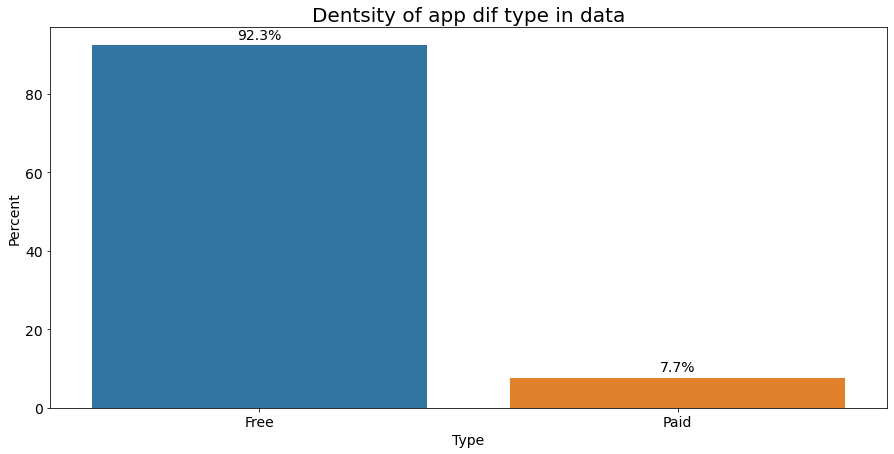

In [60]:
norm_target = (df
               .Type
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14)

plt.title('Dentsity of app dif type in data', fontsize=20)

plt.xlabel('Type', fontsize=14)
plt.ylabel('Percent', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Наверное, с этого графика столило начать. В принципе посмотреть на распределение данных по категории. Хоть это никак не влияет на графики/данные рассмотренные ранее, но к сведению примем, что платные приложения всего 7.7% от всей выборки.

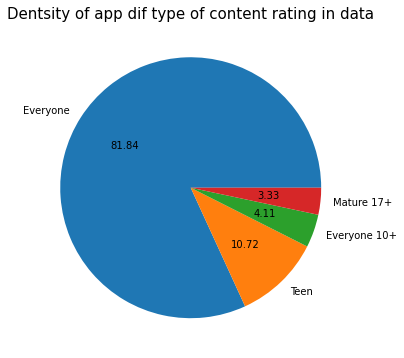

In [93]:
plt.figure(figsize=(6, 6))
plt.pie(x=df['Content Rating'].value_counts(), autopct="%.2f", labels = df['Content Rating'].unique())
plt.title('Dentsity of app dif type of content rating in data', fontsize=15)
plt.show()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9644 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   App                9644 non-null   object 
 1   Category           9644 non-null   object 
 2   Rating             8196 non-null   float64
 3   Reviews            9644 non-null   int32  
 4   Size               9644 non-null   float64
 5   Installs           9644 non-null   object 
 6   Type               9644 non-null   object 
 7   Price              9644 non-null   float64
 8   Content Rating     9644 non-null   object 
 9   Genres             9644 non-null   object 
 10  Android Ver        9642 non-null   object 
 11  days_after_update  9644 non-null   int64  
 12  tracking           9644 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(8)
memory usage: 1.2+ MB


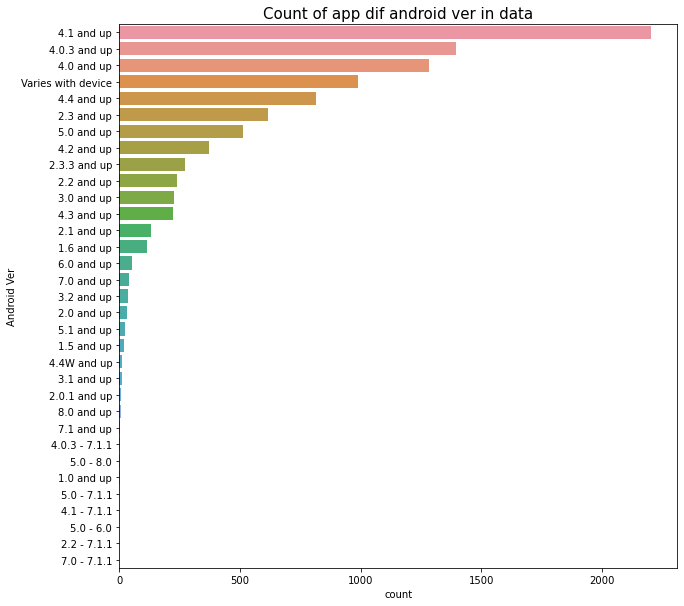

In [107]:
plt.figure(figsize=(10,10))
sns.countplot(y = df['Android Ver'], order = df['Android Ver'].value_counts().index)
plt.title('Count of app dif android ver in data', fontsize=15)
plt.show()

Как и было отмечено раньше, приложений, поддерживающихся более стареньким андроидом куда больше, чем приложений на свежую версию ОС. Так что, чтобы не терять потенциальных пользователей, разработчикам стоит как можно дольше оптимизировать свои приложения под ранние версии ОС.

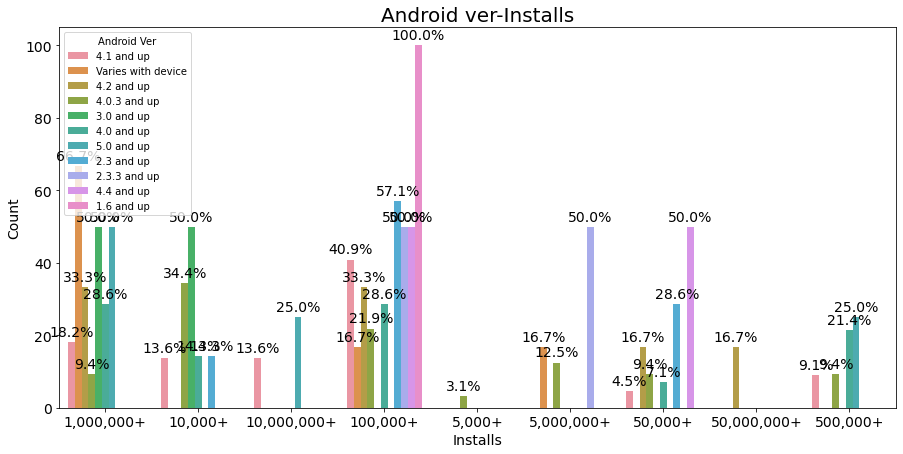

In [113]:
df_rating_type = df.loc[df.Rating > 4][:100]

plt.figure(figsize=(15, 7))

educ_def = (df_rating_type.groupby(['Android Ver'])['Installs']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('Installs'))

ax = sns.barplot(x="Installs", y="percentage", hue="Android Ver", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Android ver-Installs', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Installs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Может не самый репрезентативный график, так как я беру не все подходящие под условие(большой рейтинг) записи. Но на мой взгляд все равно очень показательный. Приложения с большим рейтингом и скачиваниями (что потенциально приносит прибыль) поддерживаются самыми ранними версиями андроида (некоторые из них выходили более 10 лет назад).

### Вывод

Я рассмотрел открытй набор данных, содержащий информацию о приложениях из разных категорий, с разными параметрами, которые можно скачать из Play Market. Данные были обработаны: ненужные удалены; проведен небольшой fe, добавил несколько колонок на основании имеющихся данных, которые впоследствии использовал; построил графики различных типов для наглядного представления данных. 

Мной были выдвинуты несколько гипотез (с точки зрения простого пользователя), часть из них была опровергнута, часть подтвердилась.

Что сделать не удалось: в данных остались пропуски. К их заполнению применимы разные алгоритмы, один из которых это построение логистичееской регрессии на имеющихся данных для заполнения пропусков. В принципе могу предположить, что можно создать еще какие-то дополнительный фичи из имеющихся для дальнейшего анализа.

Какие гипотезы глобальней я бы мог выделить: с этими данными были выгружены отзывы пользователей обо всех представленных приложениях, можно было бы их обработать, чтобы выявить какие-то паттерны (более чем уверен, что они есть (наподобие того: есть ли свзяь между длиной отзыва и рейтингом, выявить пол комментатора и посмотреть есть ли связь между полом комментатора и рейтингом который он оставляет); можно было бы попробовать оценить "сезонность" приложений, когда происходит и происходит ли вообще пик комментариев/оставления оценок за год, попробовать выяснить почему это происходит). 